##### `Ensemble Techniques`
###### <b>`Task: Loan_Status(col) to be granted or not granted based on other cols`<b>

Actual train_loan.csv file data (58645, 13)
No Duplicates Found
Train Model Score: 0.87
Test Model Score: 0.87
F1 Test : 0.6870
Best RFC Train Model Score: 0.94
Best RFC Test Model Score: 0.94
Best RFC F1 Test : 0.8618
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10087
           1       0.92      0.64      0.76      1642

    accuracy                           0.94     11729
   macro avg       0.93      0.82      0.86     11729
weighted avg       0.94      0.94      0.94     11729



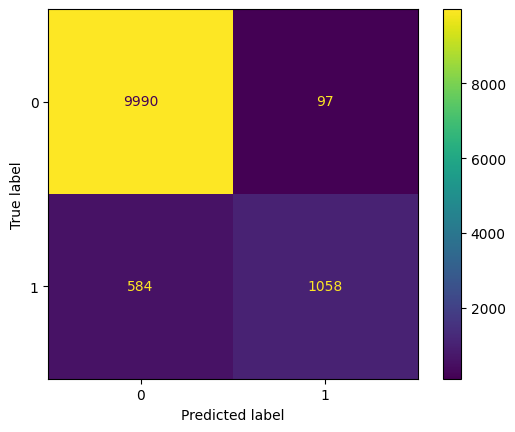

In [12]:
from warnings import filterwarnings; filterwarnings("ignore")

#----------------------
#Step-1: Data Ingestion
#----------------------

import pandas as pd; df = pd.read_csv("train_loan.csv"); print('Actual train_loan.csv file data', df.shape)

#----------------------------------------
#Step-2: Data Sanity - Duplicate removals
#----------------------------------------

duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f'Duplicates Found: {duplicate_count}'); print('Removing Duplicates...')
    df = df.drop_duplicates(keep = "first").reset_index(drop = True)
    print('Removed Duplicates...')
else:
    print('No Duplicates Found')

#------------------------
#Step-3: Separate X and Y
#------------------------

X = df.drop(columns = ["id", "loan_status"]); Y = df["loan_status"]

#-----------------------------------
#Step-4: Remove High Unique Cat Cols
#-----------------------------------

card = df.select_dtypes(include = "object").nunique() / len(df)
X = X.drop(columns = card[card >= 0.9].index)

#------------------------
#Step-5: Train Test Split
#------------------------

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

#--------------------------------
#Step-6: Apply Preprocessing on X
#--------------------------------

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy= "most_frequent"),
                         OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))

num_cols= X.select_dtypes(include="number").columns; cat_cols= X.select_dtypes(include = "object").columns

pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)]).set_output(transform="pandas")
pre.fit(xtrain)

xtrain_pre = pre.transform(xtrain); xtest_pre = pre.transform(xtest)

#--------------------
#Step-7: Build Models
#--------------------

#------------------------------
# Model: RandomForestClassifier
#------------------------------

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators= 1, max_depth= 1, min_samples_split= 5, min_samples_leaf= 5)
rfc.fit(xtrain_pre, ytrain)
print(f'Train Model Score: {rfc.score(xtrain_pre, ytrain):.2f}')
print(f'Test Model Score: {rfc.score(xtest_pre, ytest):.2f}')

#F1 Test
#=======
from sklearn.metrics import f1_score
ytest_prediction = rfc.predict(xtest_pre)
f1_test = f1_score(ytest, ytest_prediction, average = "macro")
print(f"F1 Test : {f1_test:.4f}")

#-----------------------------
#Step-8: Hyperparameter Tuning
#-----------------------------
from sklearn.model_selection import RandomizedSearchCV
base = RandomForestClassifier(random_state=42)
params = {"n_estimators": [50, 100, 150], "max_depth": [3, 4, 5, 6]}
rscv_rf = RandomizedSearchCV(base, params, cv=5, scoring = "f1_macro")
rscv_rf.fit(xtrain_pre, ytrain)

best_rfc = rscv_rf.best_estimator_
print(f'Best RFC Train Model Score: {best_rfc.score(xtrain_pre, ytrain):.2f}')
print(f'Best RFC Test Model Score: {best_rfc.score(xtest_pre, ytest):.2f}')

ytest_prediction = best_rfc.predict(xtest_pre)
best_rfc_f1_test = f1_score(ytest, ytest_prediction, average="macro")
print(f"Best RFC F1 Test : {best_rfc_f1_test:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_rfc, xtest_pre, ytest)

from sklearn.metrics import classification_report
print(classification_report(ytest, ytest_prediction))

In [14]:
#-------------------------------------
# Gradient Boosting
# Model: HistGradientBoostingClassifier
#--------------------------------------
from sklearn.ensemble import HistGradientBoostingClassifier

print('Hist Gradient Boosting Classifier...', '\n')

hgbc = HistGradientBoostingClassifier(learning_rate=0.001, max_depth=1)
hgbc.fit(xtrain_pre, ytrain)

print(f'HGBC Model Train Data Score: {hgbc.score(xtrain_pre, ytrain)}')
print(f'HGBC Model Test Data Score: {hgbc.score(xtest_pre, ytest)}')

ytest_prediction = hgbc.predict(xtest_pre)
hgbc_f1_test = f1_score(ytest, ytest_prediction, average = "macro")
print(f"HGBC F1 Test : {hgbc_f1_test:.4f}")

base = HistGradientBoostingClassifier(random_state=42)
params = {"learning_rate": [0.05, 0.1, 0.15, 0.2], "max_depth": [2, 3, 4, 5], "max_iter":[100, 200, 300]}

rscv_hgbc = RandomizedSearchCV(base, params, cv=5, scoring="f1_macro")
rscv_hgbc.fit(xtrain_pre, ytrain)

best_hgbc = rscv_hgbc.best_estimator_

print(f'Best HGBC Model Train Data Score: {best_hgbc.score(xtrain_pre, ytrain):.2f}')
print(f'Best HGBC Model Test Data Score: {best_hgbc.score(xtest_pre, ytest):.2f}')

ytest_prediction = best_hgbc.predict(xtest_pre)
best_hgbc_f1_test = f1_score(ytest, ytest_prediction, average = "macro")
print(f"Best HGBC F1 Test : {best_hgbc_f1_test:.4f}")

Hist Gradient Boosting Classifier... 

HGBC Model Train Data Score: 0.8570210589138034
HGBC Model Test Data Score: 0.8600051155256203
HGBC F1 Test : 0.4624
Best HGBC Model Train Data Score: 0.96
Best HGBC Model Test Data Score: 0.95
Best HGBC F1 Test : 0.8944


XGB Classifier... 

XGBC Train Model Score: 0.9557507033847727
XGBC Test Model Score: 0.9516582828885668


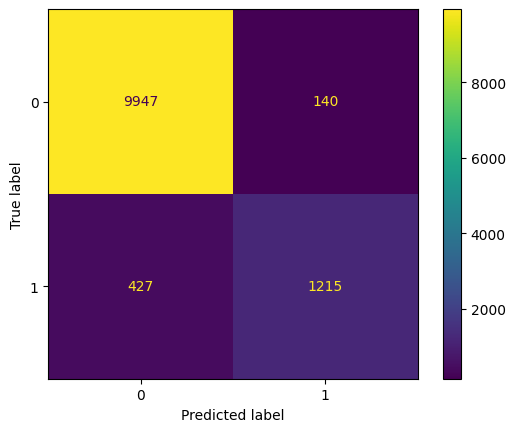

In [15]:
#-------------------------------------
# Gradient Boosting
# Model: XGB Classifier
#--------------------------------------

from xgboost import XGBClassifier

print('XGB Classifier...', '\n')

xgb = XGBClassifier(n_estimators = 200, max_depth = 3)
xgb.fit(xtrain_pre, ytrain)

print(f'XGBC Train Model Score: {xgb.score(xtrain_pre, ytrain)}')
print(f'XGBC Test Model Score: {xgb.score(xtest_pre, ytest)}')

ConfusionMatrixDisplay.from_estimator(xgb, xtest_pre, ytest)

In [11]:
#---------------------------------------------------
#Step-10: Model Inference (Out of Sample Prediction)
#---------------------------------------------------

xnew = pd.read_csv("test_loan.csv")
xnew_pre = pre.transform(xnew)

preds = best_hgbc.predict(xnew_pre)
preds[0:5]
probs = best_hgbc.predict_proba(xnew_pre)[:, 1]
probs[0:5]

array([0.99585414, 0.0172219 , 0.78120013, 0.00995329, 0.06281662])